<a href="https://colab.research.google.com/github/Galaxy-Feng/repository-one/blob/main/%E5%A4%9A%E5%B1%82%E6%84%9F%E7%9F%A5%E6%9C%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 新段落

Epoch 1, Train Loss: 1.0415, Train Acc: 0.6396, Test Acc: 0.7102
Epoch 2, Train Loss: 0.5993, Train Acc: 0.7891, Test Acc: 0.8053
Epoch 3, Train Loss: 0.5168, Train Acc: 0.8192, Test Acc: 0.8187
Epoch 4, Train Loss: 0.4795, Train Acc: 0.8331, Test Acc: 0.8324
Epoch 5, Train Loss: 0.4522, Train Acc: 0.8408, Test Acc: 0.8287
Epoch 6, Train Loss: 0.4340, Train Acc: 0.8471, Test Acc: 0.8347
Epoch 7, Train Loss: 0.4176, Train Acc: 0.8518, Test Acc: 0.8338
Epoch 8, Train Loss: 0.4008, Train Acc: 0.8590, Test Acc: 0.8450
Epoch 9, Train Loss: 0.3895, Train Acc: 0.8619, Test Acc: 0.8440
Epoch 10, Train Loss: 0.3808, Train Acc: 0.8647, Test Acc: 0.8431


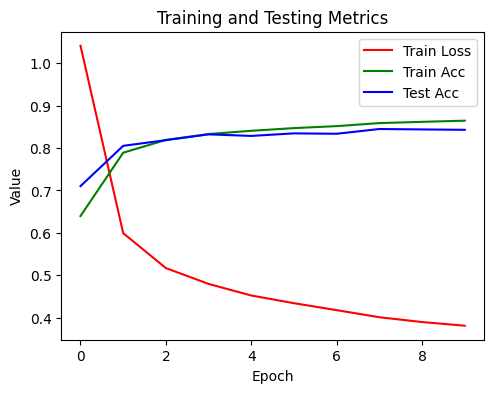

In [15]:
import torch
from torch import nn
import tensorflow as tf
import matplotlib.pyplot as plt

batch_size = 256
fashion_mnist = tf.keras.datasets.fashion_mnist
(trainImages, trainLabels), (testImages, testLabels) = fashion_mnist.load_data()
trainImages = torch.tensor(trainImages, dtype=torch.float32).div(255)
trainLabels = torch.tensor(trainLabels, dtype=torch.long)
testImages = torch.tensor(testImages, dtype=torch.float32).div(255)
testLabels = torch.tensor(testLabels, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(trainImages, trainLabels)
test_dataset = torch.utils.data.TensorDataset(testImages, testLabels)

train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
params = [W1, b1, W2, b2]

def relu(X):
    return torch.max(X, torch.zeros_like(X))

def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X @ W1 + b1)
    return H @ W2 + b2

loss = nn.CrossEntropyLoss(reduction='none')

class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.size(0))
    return metric[0] / metric[1]

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    train_losses = []
    train_accs = []
    test_accs = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'r', label='Train Loss')
    plt.plot(train_accs, 'g', label='Train Acc')
    plt.plot(test_accs, 'b', label='Test Acc')
    plt.title('Training and Testing Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

    plt.show()

num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)

train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)